In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [26]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [7]:
num_users = rating_df['user'].nunique()
num_items = rating_df['item'].nunique()
print(f"users: {num_users}\nitems: {num_items}")

users: 33901
items: 126


In [23]:
class RecommenderNetwork(keras.Model):
    def __init__(self,num_users,num_items,embedding_size=16,**kwargs):
        super(RecommenderNetwork,self).__init__(**kwargs)
        self.num_users = num_users  
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        self.user_embedding_layer = layers.Embedding(
            input_dim = num_users,
            output_dim = embedding_size,
            name = 'user_embedding_layer',
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6),
        )
        
        self.user_bias = layers.Embedding(
            input_dim = num_users,
            output_dim = 1,
            name= 'user_bias',
        )
        
        self.item_embedding_layer = layers.Embedding(
            input_dim = num_items,
            output_dim = embedding_size,
            name = 'item_embedding_layer',
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6),
        )
        
        self.item_bias = layers.Embedding(
            input_dim = num_items,
            output_dim = 1,
            name = 'item_bias',
        )
    
    def call(self,inputs):
        user_vector = self.user_embedding_layer(inputs[:,0])
        user_bias = self.user_bias(inputs[:,0])
        item_vector = self.item_embedding_layer(inputs[:,1])
        item_bias = self.item_bias(inputs[:,1])
        dot_user_item = tf.tensordot(user_vector,item_vector,2)
        x = dot_user_item + user_bias + item_bias
        
        return tf.nn.relu(x)

In [11]:
def process_dataseet(raw_data):
    encoded_data = raw_data.copy()
    
    user_list = encoded_data['user'].unique().tolist()
    user_id2idx_dict = {x:i for i,x in enumerate(user_list)}
    user_idx2id_dict = {i:x for i,x in enumerate(user_list)}
    
    course_list = encoded_data['item'].unique().tolist()
    course_id2idx_dict = {x:i for i,x in enumerate(course_list)}
    course_idx2id_dict = {i:x for i,x in enumerate(course_list)}
    
    encoded_data['user'] = encoded_data['user'].map(user_id2idx_dict)
    encoded_data['item'] = encoded_data['item'].map(course_id2idx_dict)
    encoded_data['rating'] = encoded_data['rating'].values.astype('int')
    
    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [12]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataseet(rating_df)

In [13]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


In [14]:
def generate_train_test_dataset(dataset,scale=True):
    min_rating = min(dataset['rating'])
    max_rating = max(dataset['rating'])
    
    dataset = dataset.sample(frac=1,random_state=42)
    x = dataset[['user','item']].values
    if scale:
        y = dataset['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values
    else:
        y = dataset['rating'].values
        
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])
    
    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:]
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [15]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_dataset(encoded_data)

In [16]:
user_indices = x_train[:,0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973], dtype=int64)

In [17]:
item_indices = x_train[:,1]
item_indices

array([12, 29,  3, ..., 18, 19, 17], dtype=int64)

In [18]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

In [24]:
embedding_size = 16
model = RecommenderNetwork(num_users,num_items,embedding_size)

In [37]:
model.summary()

Model: "recommender_network_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding_layer (Embed  multiple                 542416    
 ding)                                                           
                                                                 
 user_bias (Embedding)       multiple                  33901     
                                                                 
 item_embedding_layer (Embed  multiple                 2016      
 ding)                                                           
                                                                 
 item_bias (Embedding)       multiple                  126       
                                                                 
Total params: 578,459
Trainable params: 578,459
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x=x_train,y=y_train,batch_size=64,epochs=10,verbose=1,validation_data=(x_val,y_val))


Epoch 1/10
2917/2917 [==============================] - 41s 14ms/step - loss: 0.0462 - root_mean_squared_error: 0.2142 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2013
Epoch 2/10
2917/2917 [==============================] - 37s 13ms/step - loss: 0.0366 - root_mean_squared_error: 0.1890 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1738
Epoch 3/10
2917/2917 [==============================] - 36s 12ms/step - loss: 0.0243 - root_mean_squared_error: 0.1525 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1520
Epoch 4/10
2917/2917 [==============================] - 37s 13ms/step - loss: 0.0191 - root_mean_squared_error: 0.1339 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1418
Epoch 5/10
2917/2917 [==============================] - 39s 14ms/step - loss: 0.0162 - root_mean_squared_error: 0.1221 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1359
Epoch 6/10
2917/2917 [==============================] - 38s 13ms/step - loss: 0.0144 - root_mean_squared_error: 0.1138 -

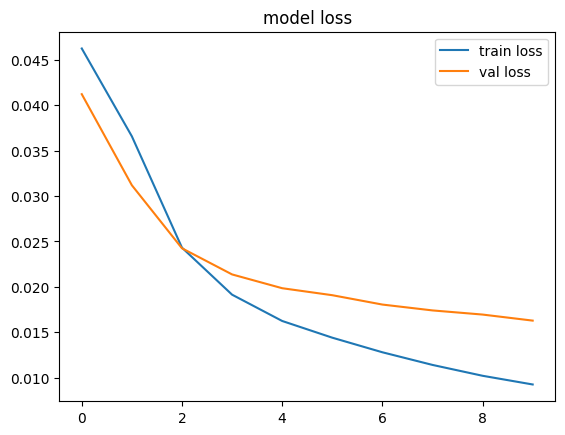

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train loss','val loss'],loc='upper right')

In [88]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


In [35]:
model.evaluate(x_test,y_test)

730/730 [==============================] - 6s 8ms/step - loss: 0.0155 - root_mean_squared_error: 0.1173


[0.015485147945582867, 0.11734103411436081]

In [38]:
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
user_latent_features.shape

(33901, 16)

In [39]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
item_latent_features.shape

(126, 16)

In [41]:
# class CustomRecommenderNetwork(keras.Model):
#     def __init__(self, num_users, num_items, embedding_size=16, hidden_units=[64, 32], activation='relu', **kwargs):
#         super(CustomRecommenderNetwork, self).__init__(**kwargs)
#         self.num_users = num_users
#         self.num_items = num_items
#         self.embedding_size = embedding_size

#         self.user_embedding_layer = layers.Embedding(
#             input_dim=num_users,
#             output_dim=embedding_size,
#             name='user_embedding_layer',
#             embeddings_initializer='he_normal',
#             embeddings_regularizer=keras.regularizers.l2(1e-6),
#         )

#         self.user_bias = layers.Embedding(
#             input_dim=num_users,
#             output_dim=1,
#             name='user_bias',
#         )

#         self.item_embedding_layer = layers.Embedding(
#             input_dim=num_items,
#             output_dim=embedding_size,
#             name='item_embedding_layer',
#             embeddings_initializer='he_normal',
#             embeddings_regularizer=keras.regularizers.l2(1e-6),
#         )

#         self.item_bias = layers.Embedding(
#             input_dim=num_items,
#             output_dim=1,
#             name='item_bias',
#         )

#         self.hidden_layers = []
#         for units in hidden_units:
#             self.hidden_layers.append(layers.Dense(units, activation=activation))

#         self.output_layer = layers.Dense(1, activation='relu')

#     def call(self, inputs):
#         user_vector = self.user_embedding_layer(inputs[:, 0])
#         user_bias = self.user_bias(inputs[:, 0])
#         item_vector = self.item_embedding_layer(inputs[:, 1])
#         item_bias = self.item_bias(inputs[:, 1])
#         dot_user_item = tf.tensordot(user_vector, item_vector, 2)
#         x = dot_user_item + user_bias + item_bias

#         for layer in self.hidden_layers:
#             x = layer(x)

#         return self.output_layer(x)


In [81]:
item_df = pd.DataFrame(rating_df['item'].unique())
item_df.columns = ['item']
item_col_rename = ['CFeature'+str(i) for i in range(16)]
i_latent_features = pd.DataFrame(item_latent_features)
i_latent_features.columns = item_col_rename
item_emb = pd.concat([item_df,i_latent_features],axis=1)

In [82]:
user_df = pd.DataFrame(rating_df['user'].unique())
user_df.columns = ['user']
user_col_rename = ['UFeature'+str(i) for i in range(16)]
u_latent_features = pd.DataFrame(user_latent_features)
u_latent_features.columns = user_col_rename
user_emb = pd.concat([user_df,u_latent_features],axis=1)

In [85]:
# item_emb.to_csv('./data/course_embeddings.csv',index=False)
# user_emb.to_csv('./data/user_embeddings.csv',index=False)